# The Evolution of Music Structure from a Fractal Perspective using Detrended Fluctuation Analysis

In [ ]:
from scipy.stats import skew, kurtosis, linregress, iqr
from scipy.signal import hilbert, resample
from scipy.ndimage import uniform_filter1d
import re
import pandas as pd
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from pydub import AudioSegment
import seaborn as sns
import json
import matplotlib.ticker as ticker
from matplotlib.ticker import MaxNLocator
import tinytag

sns.set_theme(style="whitegrid", context="paper", font_scale=1.2)
# Get repo root directory for portable paths
import os
from pathlib import Path

def apply_black_box(ax=None):
    """Apply black border box and tidy formatting to a matplotlib Axes."""
    import matplotlib.pyplot as plt

    if ax is None:
        ax = plt.gca()

    # Enable all spines and set them to black
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_color("black")

    # Optional: other default styling
    ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.6)

def save_plot(base_path, dpi=600):
    # Ensure directory exists
    os.makedirs(os.path.dirname(base_path), exist_ok=True)

    # Save as PDF (vector quality, best for LaTeX/Overleaf)
    plt.savefig(f"{base_path}.pdf", bbox_inches='tight')

    # Save as PNG (high-res raster, useful for slides/web)
    plt.savefig(f"{base_path}.png", dpi=dpi, bbox_inches='tight')

## 1 Music Structure Representation - Amplitude Envelope
Show the evolution real music from a fractal perspective by analyzing the amplitude envelope. We use this signal because the raw waveform is too oscillatory, containing all the fast variations due to pitch and harmonics. The amplitude envelope smooths this out and captures the **energy dynamics** or **loudness contour** over time, which aligns more closely with human perception. To increase the calculation efficiency, all audio is downsampled to 150 Hz as auditory tracking capacity extends up to ~120–150 Hz (Brian Moore’s An Introduction to the Psychology of Hearing (6th Edition). After testing different smoothing windows, a minimal 25 ms best retained relevant music features (mean $\alpha=0.9925$) while not cutting out too much, corresponding to a 20 Hz low-pass filter: $$T = 25 \text{ ms} = 0.025 \text{ s}, \:
f_c \approx \frac{1}{2 \times 0.025} = 20 \text{ Hz}$$ Smoothing is first applied followed by downsampling to reduce the risk of introducing aliasing artifacts.

In [2]:
# === 1. Load and Normalize Audio ===
def load_audio(path, target_sr=22050):
    audio = AudioSegment.from_mp3(path).set_channels(1).set_frame_rate(target_sr)
    samples = np.array(audio.get_array_of_samples()).astype(np.float32)
    samples /= np.iinfo(audio.array_type).max
    return samples, target_sr

# === 2. Compute Smoothed Envelope ===
def compute_smoothed_envelope(samples, orig_sr=22050, target_sr=150, smooth_ms=25):
    analytic = hilbert(samples)
    envelope = np.abs(analytic)

    smooth_len = int((smooth_ms / 1000) * orig_sr)
    if smooth_len > 1:
        envelope = uniform_filter1d(envelope, size=smooth_len)

    n_samples = int(len(envelope) * (target_sr / orig_sr))
    envelope = resample(envelope, n_samples)
    return envelope, target_sr

## DFA of Amplitude Envelope Between AI and Real Music

In [5]:
# Load datasets

# Get repo root directory (works in Jupyter notebooks)
REPO_ROOT = Path(os.getcwd()).resolve()
billboard = pd.read_csv(REPO_ROOT / "reference_data" / "dfa" / "smooth_ms_25_downsample_150_hz" / "billboard.csv")
diffrhythm = pd.read_csv(REPO_ROOT / "reference_data" / "dfa" / "smooth_ms_25_downsample_150_hz" / "diffrhythm.csv")
suno = pd.read_csv(REPO_ROOT / "reference_data" / "dfa" / "smooth_ms_25_downsample_150_hz" / "suno.csv")
yue = pd.read_csv(REPO_ROOT / "reference_data" / "dfa" / "smooth_ms_25_downsample_150_hz" / "yue.csv")

billboard["source"] = "BB"
suno["source"] = "Suno"
diffrhythm["source"] = "DR"
yue["source"] = "YuE"

palette = {
    "BB": sns.color_palette("deep")[0],
    "Suno": sns.color_palette("deep")[1],
    "DR": sns.color_palette("deep")[2],
    "YuE": sns.color_palette("deep")[3],
}

# read the first few lines
billboard.head()

FileNotFoundError: [Errno 2] No such file or directory: '/home/data/kevinzhang/research/fractal_analysis/notebooks/reference_data/dfa/smooth_ms_25_downsample_150_hz/billboard.csv'

0.9460697825736358 BB
1.0886577696954396 Suno
1.1197021308917088 DR
1.072467909652961 YuE
If I Ain't Got You? – Alicia Keys (2004, Rank 3)


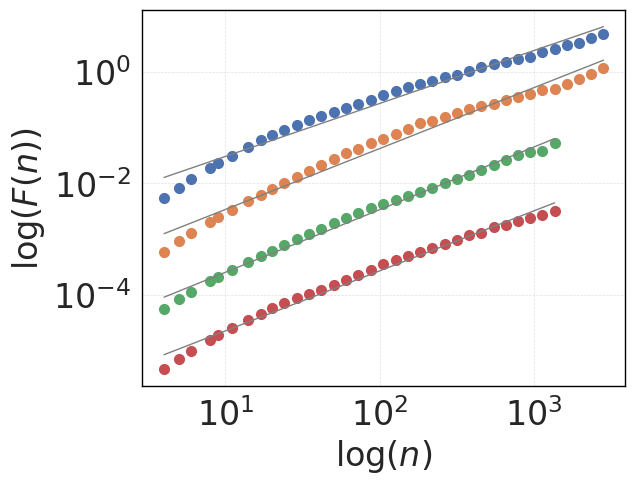

In [ ]:
all_data = pd.concat([billboard, suno, diffrhythm, yue], ignore_index=True)
all_data["position"] = pd.to_numeric(all_data["position"], errors="coerce")

# === Select a Random Song with Valid Log Data ===
valid = all_data[all_data["log_n"].notna() & all_data["log_fn"].notna()]
# random_song = valid.sample(1, random_state=None).iloc[0]
# year = int(random_song["year"])
# title = random_song["title"]
# artist = random_song["artist"]
# rank = int(random_song["position"])

year = 2004
title = "If I Ain't Got You?"
artist = "Alicia Keys"
rank = 3

# === Get All Versions of That Song ===
same_song = all_data[(all_data["year"] == year) & (all_data["position"] == rank)]

# === Plot DFA Log-Log Plot ===
plt.figure(figsize=(6.5, 5))
offset_map = {
    "BB": 0.0,
    "Suno": -1.0,
    "DR": -2.0,
    "YuE": -3.0,
}

for _, row in same_song.iterrows():
    model = row["source"]
    if model not in offset_map or pd.isna(row["log_n"]) or pd.isna(row["log_fn"]):
        continue

    try:
        log_n = np.array(json.loads(row["log_n"]))
        log_fn = np.array(json.loads(row["log_fn"]))
    except Exception:
        continue

    n_vals = np.exp(log_n)
    fn_vals = np.exp(log_fn)
    offset = offset_map[model]

    slope, intercept, _, _, _ = linregress(log_n, log_fn)
    fitted_line = np.exp(slope * log_n + intercept)

    label = f"{model} (α ≈ {slope:.3f})"
    plt.plot(n_vals, fn_vals * 10 ** offset, 'o', label=label, color=palette[model], markersize=7)
    plt.plot(n_vals, fitted_line * 10 ** offset, '-', color='grey', linewidth=1)
    print(slope, model)

print(f"{title} – {artist} ({year}, Rank {rank})")

# === Formatting ===
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$\log(n)$", fontsize=24)
plt.ylabel(r"$\log(F(n))$", fontsize=24)

# Increase tick label font size
plt.tick_params(axis='both', which='major', labelsize=24)
# plt.gca().yaxis.set_major_locator(MaxNLocator(nbins=5))  # Limit y-axis tick count
plt.grid(True, linestyle="--", linewidth=1.0)
sns.despine()
apply_black_box()
plt.tight_layout()
plt.show()

## Evolution of the Structure of Music with DFA (1950-2024)

/tmp/ipykernel_256216/1267276858.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


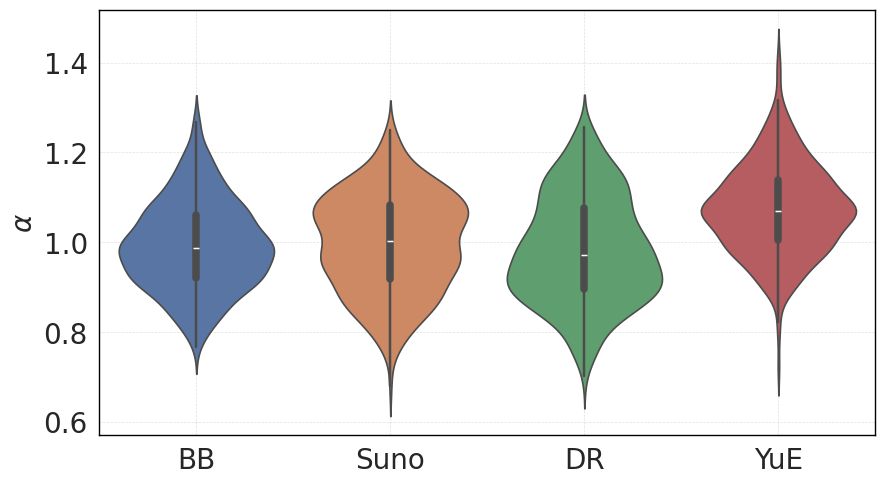

In [ ]:
# === Combine All into One DataFrame ===
alpha_df = pd.concat([billboard, suno, diffrhythm, yue], ignore_index=True)

# === Violin Plot ===
plt.figure(figsize=(9, 5))
sns.violinplot(
    data=alpha_df, 
    x="source", 
    y="alpha", 
    palette=palette, 
    inner="box", 
    linewidth=1.2
)

plt.xlabel("")
plt.ylabel(r"$\alpha$", fontsize=16)
# increase y and x ticks
plt.yticks(fontsize=20)
# increase y label size
plt.ylabel(r"$\alpha$", fontsize=20)
plt.xticks(fontsize=20)  # Increase x-axis tick label font size
plt.grid(True, axis='y', linestyle='--', linewidth=0.6, alpha=0.5)
sns.despine()
apply_black_box()
plt.tight_layout()

plt.show()

Fig. 2 shows the DFA α distributions across all songs. Billboard tracks cluster tightly around α ≈ 1, consistent with prior literature. The AI models deviate:
	•	Suno and DiffRhythm have broader, more symmetric distributions.
	•	YuE shows a skew toward higher α values, with a heavier tail.

Descriptive statistics (Table X) support this:
	•	Range: YuE and DiffRhythm have comparable or larger ranges than Billboard, countering the claim of reduced diversity.
	•	Skewness: YuE is right-skewed (positive), indicating a bias toward higher α.
	•	Kurtosis: Billboard has moderate kurtosis, while YuE and DiffRhythm display heavier tails, suggesting more extreme values at both ends.

/tmp/ipykernel_256216/2117182444.py:11: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=dfa_billboard_sorted, x="year", y="alpha_ma5", color="black", ci=None)
/tmp/ipykernel_256216/2117182444.py:21: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


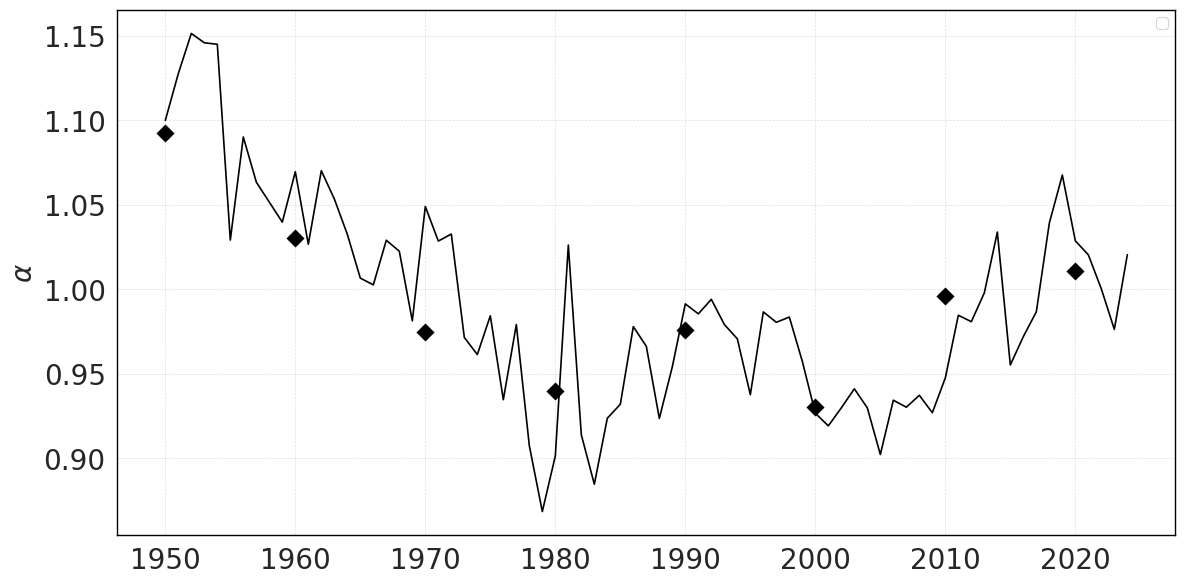

In [ ]:
# === Extract year and decade ===
for df in [billboard, suno, diffrhythm, yue]:
    df["decade"] = (df["year"] // 10 * 10).astype(int)

# === Billboard DFA α Evolution ===
dfa_billboard_sorted = billboard.sort_values("year")
dfa_billboard_sorted["alpha_ma5"] = dfa_billboard_sorted["alpha"].rolling(window=5, center=True).mean()
dfa_decade_means = dfa_billboard_sorted.groupby("decade")["alpha"].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(data=dfa_billboard_sorted, x="year", y="alpha_ma5", color="black", ci=None)
sns.scatterplot(data=dfa_decade_means, x="decade", y="alpha", s=100, marker="D", color="black")
plt.ylabel(r"$\alpha$", size=20)
plt.xlabel("")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
# plt.yticks(np.round(np.linspace(alpha.min(), alpha.max(), 6), 2), fontsize=12)  # Reduced y-ticks


plt.grid(True)
plt.legend()
plt.tight_layout()
apply_black_box()
plt.show()

This figure traces the evolution of DFA α in Billboard Top 5 songs from 1950 to 2023. The smoothed 5-year moving average reveals a notable decline in α from the 1950s through the early 2000s, followed by a modest resurgence in the 2010s. The moving average reveals:
- A decline in α from the 1950s to the 2000s, possibly reflecting increasing rhythmic complexity.
- A modest resurgence in recent years, perhaps linked to post-digital production practices emphasizing smooth transitions and looped textures.

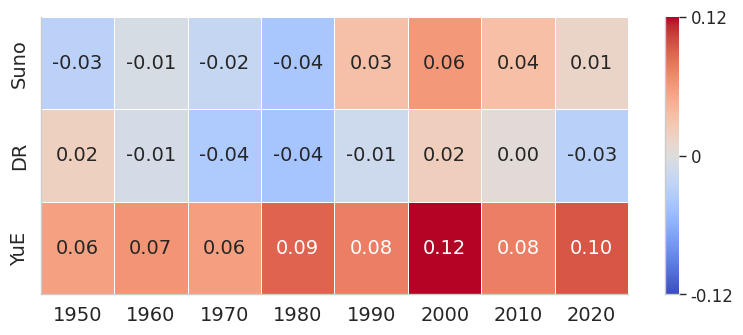

In [ ]:
# === Compute Per-Decade Mean DFA α ===
dfa_bb = billboard.groupby("decade")["alpha"].mean()
dfa_suno_avg = suno.groupby("decade")["alpha"].mean()
dfa_diff_avg = diffrhythm.groupby("decade")["alpha"].mean()
dfa_yue_avg = yue.groupby("decade")["alpha"].mean()

# === Compute Δ (AI − Billboard) ===
delta_dfa_alpha = pd.DataFrame({
    "Suno": dfa_suno_avg - dfa_bb,
    "DR": dfa_diff_avg - dfa_bb,
    "YuE": dfa_yue_avg - dfa_bb
}).T

# Calculate symmetric limits
limit = max(abs(delta_dfa_alpha.min().min()), abs(delta_dfa_alpha.max().max()))
vmin, vmax = -limit, limit
ticks = [vmin, 0, vmax]

# Create figure and axes
fig, ax = plt.subplots(figsize=(8, 3.5))

# Plot heatmap with symmetric color limits
heatmap = sns.heatmap(
    delta_dfa_alpha, cmap="coolwarm", center=0, vmin=vmin, vmax=vmax,
    annot=True, fmt=".2f", linewidths=0.5, annot_kws={"size": 14},
    ax=ax, cbar_kws={"shrink": 1.0}
)

# Adjust colorbar
cbar = heatmap.collections[0].colorbar
cbar.set_ticks(ticks)
cbar.set_ticklabels([f"{ticks[0]:.2f}", "0", f"{ticks[2]:.2f}"])
cbar.ax.tick_params(labelsize=12)

# Format axes
ax.set_xlabel("")
ax.set_ylabel("")
ax.tick_params(labelsize=14)
sns.despine()
plt.tight_layout()
plt.show()

- YuE overshoots in every decade post-1970, peaking in the 2000s (+0.12).
- Suno stays close to Billboard, with minor positive deviation in recent decades.
- DiffRhythm fluctuates, but generally maintains neutral to slightly negative bias.


In [ ]:
# === Helper: Construct label string from columns ===
def create_song_label(row):
    return f"{row['title']} – {row['artist']} ({int(row['year'])}, Rank {row['position']})"

# === Function to summarize DFA alpha stats ===
def summarize_dfa_alpha(df, label):
    df = df.copy()
    df["label"] = df.apply(create_song_label, axis=1)

    min_alpha = df["alpha"].min()
    max_alpha = df["alpha"].max()
    closest_idx = (df["alpha"] - 1).abs().idxmin()
    closest_song = df.loc[closest_idx, "label"]
    closest_value = round(df.loc[closest_idx, "alpha"], 3)
    median = round(df["alpha"].median(), 3)
    iqr_val = round(iqr(df["alpha"]), 3)
    mad_val = round(np.median(np.abs(df["alpha"] - median)), 3)
    alpha_lt_1 = (df["alpha"] < 1).sum()
    alpha_gt_1 = (df["alpha"] > 1).sum()
    total = len(df)
    outliers = ((df["alpha"] < (median - 1.5 * iqr_val)) | (df["alpha"] > (median + 1.5 * iqr_val))).sum()
    percent_outliers = round(100 * outliers / total, 1)

    return {
        "Model": label,
        "Closest to α = 1": closest_song,
        "Closest α": closest_value,
        "Min α": round(min_alpha, 3),
        "Min α Song": df.loc[df["alpha"].idxmin(), "label"],
        "Max α": round(max_alpha, 3),
        "Max α Song": df.loc[df["alpha"].idxmax(), "label"],
        "Mean": round(df["alpha"].mean(), 3),
        "Std Dev": round(df["alpha"].std(), 3),
        "Skewness": round(skew(df["alpha"]), 3),
        "Range": round(max_alpha - min_alpha, 3),
        "Kurtosis": round(kurtosis(df["alpha"]), 3),
        "Median": median,
        "IQR": iqr_val,
        "MAD": mad_val,
        "# α < 1": alpha_lt_1,
        "# α > 1": alpha_gt_1,
        "% Outliers": percent_outliers,
    }


# === Collect summaries ===
dfa_stats = pd.DataFrame([
    summarize_dfa_alpha(billboard, "Billboard"),
    summarize_dfa_alpha(suno, "Suno"),
    summarize_dfa_alpha(diffrhythm, "DiffRhythm"),
    summarize_dfa_alpha(yue, "YuE")
])

# === Display and Save ===
from IPython.display import display
display(dfa_stats)

,Model,Closest to α = 1,Closest α,Min α,Min α Song,Max α,Max α Song,Mean,Std Dev,Skewness,Range,Kurtosis,Median,IQR,MAD,# α < 1,# α > 1,% Outliers
0,Billboard,"Bad Day – Daniel Powter (2006, Rank 1)",1.0,0.767,"Let Me Love You – Mario (2005, Rank 3)",1.267,"Rockstar – DaBaby feat. Roddy Ricch (2020, Ran...",0.993,0.099,0.283,0.500,-0.255,0.988,0.141,0.071,217,164,2.1
1,Suno,"Anti-Hero – Taylor Swift (2023, Rank 4)",1.0,0.679,"Love's Theme – Love Unlimited Orchestra (1974,...",1.250,"You're Beautiful – James Blunt (2006, Rank 4)",0.998,0.108,-0.156,0.571,-0.618,1.002,0.165,0.081,189,192,1.0
2,DiffRhythm,"Claudette – The Everly Brothers (1958, Rank 2b)",1.0,0.702,"Hanging By A Moment – Lifehouse (2001, Rank 1)",1.257,"Mona Lisa – Nat King Cole (1950, Rank 2)",0.983,0.118,0.214,0.555,-0.655,0.971,0.180,0.083,223,158,1.0
3,YuE,"All Shook Up – Elvis Presley (1957, Rank 1)",1.0,0.721,"Harlem Shake – Baauer (2013, Rank 4)",1.413,"Blue Tango – Leroy Anderson (1952, Rank 1)",1.074,0.100,0.183,0.692,0.462,1.070,0.134,0.067,83,264,3.5
